# What is Faber's trading strategy?

One buys when the monthly price of an asset in our portfolio exceeds its 10-month simple moving average and sells and moves to cash when the same price of that asset drops below its 10-month simple moving average. There is, however, one caveat for every monthly trading period: the total cash spent must not exceed the portfolio's total valuation. This rule is to prevent the algorithm from heavily borrowing to buy more assets. This practice is obviously very risky in practice and leads to overoptimistic results given our backtesting period is only within the past 7 or so years where the market has performed well.

# Reasons for this strategy in particular

Faber claims that a market timing strategy outperforms the market average, as shown by its consistently better performance than a simple buy-and-hold strategy. Furthermore, we can avoid look-ahead bias since our calculations are based solely on the close prices of the last trading day of each month. Then, assuming that the next trading day's price will be relatively similar to the previous day's closing price, we can reliably buy our asset at a price similar to the aforementioned closing price.

Finally, this strategy is very simple, to the point that it may be oversimplistic (we do not account for slippage or transaction costs). We buy a fixed number of shares whenever the monthly price exceeds the 10-month SMA and sell all of our shares of a particular asset when its monthly price is below the 10-month SMA. Therefore, we can confidently say that our model most likely does not suffer from overfitting.

In [2]:
%load_ext zipline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


In [8]:
# %load algos/faber.py
import sys
sys.path.append('C:/Users/William/Documents/GitHub/faber-trading-strategy/algos')
from numpy import mean
from collections import defaultdict
from zipline.api import order, order_target, record, symbol, date_rules, time_rules, schedule_function, set_slippage, slippage
from write_to_sql import run
import pandas as pd

from zipline import TradingAlgorithm
from zipline.finance import commission

priorOpen = None
priorClose = None

def initialize(context):
    """
    Stores the names of the stocks we'll be looking at.
    
    Input: a persistent namespace where we store an SID/list of SIDs
    
    Output: n/a
    """
    set_slippage(TradeAtTheCloseSlippageModel(priorOpen,priorClose,0.0))
    context.set_commission(commission.PerShare(cost=0))

    context.benchmark = symbol('SPY')

    context.symbol = [symbol('XLB'),
                      symbol('XLE'),
                      symbol('XLF'), 
                      symbol('XLK'), 
                      symbol('XLP'), 
                      symbol('XLY')]

    # skip the first 300 days of the timeframe so that we have enough data to calculate our 10 month SMA
    context.skip = 0
    context.init = True

    context.moving_avg = defaultdict(int)
    context.monthly_price = defaultdict(list) 

    # keeps track of which assets to trade 
    context.buy = []
    context.sell = []

    # skip the first 10 months so that we have enough data to establish our moving average    
    schedule_function(get_assets, date_rules.month_end(), time_rules.market_open(minutes=1))

def handle_data(context, data):
    """
    Calls the trading strategy function at the end of every month.
    
    Input: persistent namespace with SID(s) 'context', event-frame that handles look-ups of historical/current pricing data
    
    Output: some kind of action (buy/sell/nothing)
    """
    pass

def get_assets(context, data):
    """
    Although we actually trade at the beginning of the trading month, the way Zipline handles orders is that the fill prices of orders
    are the next bar's closing price. We have a list of assets we want to trade and we order_target() them, allowing us to purchase
    using the end of the previous month's closing price.
    
    Input: persistent namespace with SID(s) 'context', event-frame that handles look-ups of historical/current pricing data
    
    Output: a list of assets to trade
    """    
    context.skip += 1

    context.buy = []
    context.sell = []

    if context.skip < 10:
        for asset in context.symbol:
            price = data.current(asset, 'close')
            context.monthly_price[asset].append(price)

    else:
        for asset in context.symbol:
            price = data.current(asset, 'close')

            # Get closing price on last trading day of month
            context.monthly_price[asset].append(price)

            if context.skip > 10:
                del context.monthly_price[asset][0]

            # calculate the 10-month moving average of each asset
            context.moving_avg[asset] = mean(context.monthly_price[asset])
        
        ### Faber's trading strategy ###
        
        # if the current price exceeds moving average and we haven't already bought any shares, buy
        for asset in context.symbol:
            # the most current monthly price will be the one added most recently (so it'll be the element on the end of the list)
            if context.monthly_price[asset][-1] >= context.moving_avg[asset]:
                context.buy.append(asset)
                order_target(asset,50)

            # else if the current price is below moving average and we have 500 shares of the asset, sell
            elif context.monthly_price[asset][-1] < context.moving_avg[asset]:
                context.sell.append(asset)
                order_target(asset, 0)

    global priorOpen
    global priorClose
    
    priorOpen = {}
    priorClose = {}
    
    for sid in data:
        priorOpen[sid] = data[sid].open_price
        priorClose[sid] = data[sid].close_price
        # print sid.symbol+' prior open/close: '+str(priorOpen[sid])+'/'+str(priorClose[sid])
    
def analyze(context = None, results = None):
    """
    Plots the results of the strategy against a buy-and-hold strategy.
    
    Input: n/a?
    
    Output: a plot of two superimposed curves, one being Faber's strategy and the other being a buy-and-hold strategy.
    """
    # import matplotlib.pyplot as plt

    # txn = results['transactions']
    # txn.to_csv('transactions.csv')

    # fig = plt.figure()
    # ax1 = fig.add_subplot(211)

    # # plot both the portfolio based on faber's strategy and a buy-and-hold strategy
    # results['portfolio'].plot(ax=ax1)
    # results['SPY'].plot(ax=ax1)
    # ax1.set_ylabel('Portfolio value (USD)')

    # ax2 = fig.add_subplot(212)
    # results['returns'].plot(ax=ax2)
    # ax2.set_ylabel('Cumulative Returns')

    # results['SPY'].to_csv('benchmark.csv')
   
    # # export portfolio values to csv file
    # results['returns'].to_csv('zipline_returns.csv')

    # plt.show()

    import pyfolio as pf

    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
    transactions.to_csv("txn_end.csv")
    pf.create_simple_tear_sheet(returns, positions=positions, transactions=transactions)

    # tickers = []
    # for symbol in context.symbol:
    #     symbol = str(symbol).translate(None, '0123456789[]() ')[6:]
    #     tickers.append(symbol)

    # run('test.db', results, 'faber', tickers)

########################################################  
# Slippage model to trade at the prior close or at a fraction of the prior open - close range.  
class TradeAtTheCloseSlippageModel(slippage.SlippageModel):  
    '''Class for slippage model to allow trading at the prior close  
       or at a fraction of the prior open to close range.  
    '''  
    # Constructor, self and fraction of the prior open to close range to add (subtract)  
    # from the prior open to model executions more optimistically  
    def __init__(self, priorOpen,priorClose,fractionOfOpenCloseRange):

        # Store the percent of prior open - close range to take as the execution price  
        self.priorOpen = priorOpen
        self.priorClose = priorClose
        self.fractionOfOpenCloseRange = fractionOfOpenCloseRange

    def process_order(self, trade_bar, order):

        openPrice = priorOpen[order.sid]  
        closePrice = priorClose[order.sid]  
        ocRange = closePrice - openPrice  
        ocRange = ocRange * self.fractionOfOpenCloseRange  
        if (ocRange != 0.0):  
            targetExecutionPrice = closePrice - ocRange  
        else:  
            targetExecutionPrice = closePrice  

        return (targetExecutionPrice, order.amount)

C:\Users\William\Anaconda2\lib\site-packages\ipykernel\__main__.py:113: ZiplineDeprecationWarning: Iterating over the assets in `data` is deprecated.
C:\Users\William\Anaconda2\lib\site-packages\ipykernel\__main__.py:114: ZiplineDeprecationWarning: `data[sid(N)]` is deprecated. Use `data.current`.
C:\Users\William\Anaconda2\lib\site-packages\ipykernel\__main__.py:115: ZiplineDeprecationWarning: `data[sid(N)]` is deprecated. Use `data.current`.


Entire data start date: 2009-09-01
Entire data end date: 2017-05-01
Backtest months: 91


,Backtest
Annual return,5.8%
Cumulative returns,54.3%
Annual volatility,10.8%
Sharpe ratio,0.58
Calmar ratio,0.40
Stability,0.85
Max drawdown,-14.4%
Omega ratio,1.12
Sortino ratio,0.80
Skew,-0.58


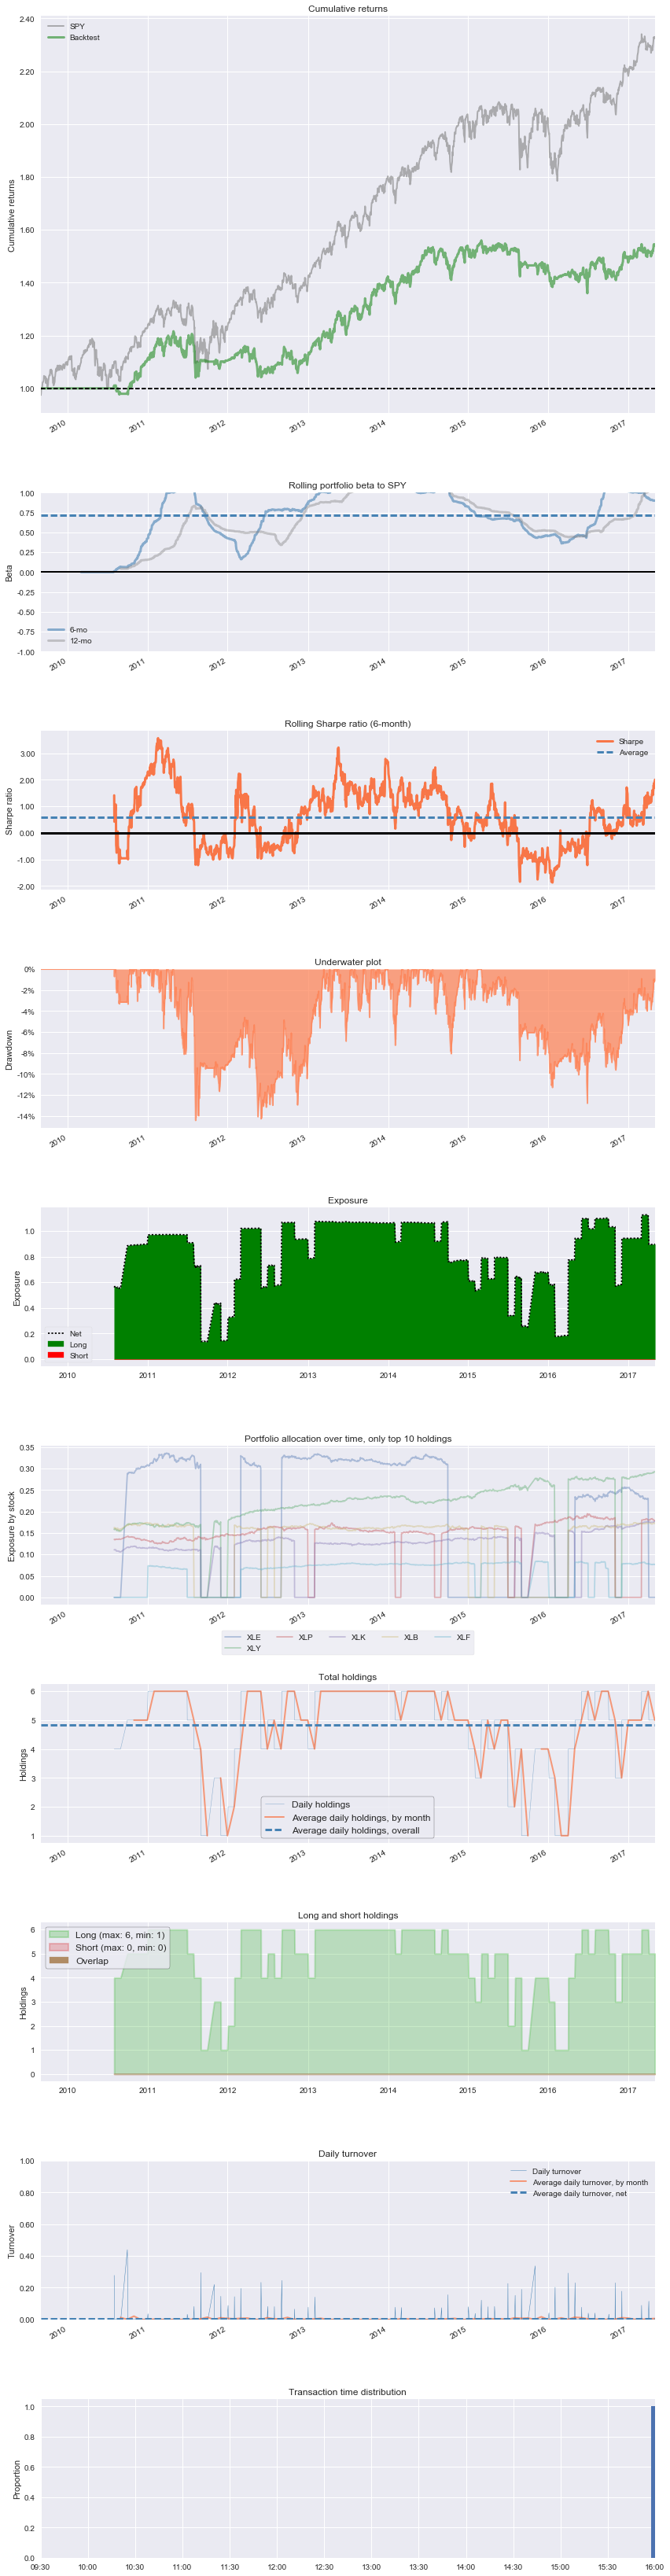

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2009-09-01 00:00:00+00:00,NaN,0.000000,NaN,-0.022057,NaN,NaN,0.0,10000.0,0.00,0.00,...,0,0,0,NaN,10000.0,0.00,0.00,1,[],0.0338
2009-09-02 00:00:00+00:00,0.000000,0.000000,0.000000,-0.025766,0.205024,0.000000,0.0,10000.0,0.00,0.00,...,0,0,0,NaN,10000.0,0.00,0.00,2,[],0.0329
2009-09-03 00:00:00+00:00,0.000000,0.000000,0.000000,-0.017665,0.242719,0.000000,0.0,10000.0,0.00,0.00,...,0,0,0,NaN,10000.0,0.00,0.00,3,[],0.0333
2009-09-04 00:00:00+00:00,0.000000,0.000000,0.000000,-0.003904,0.253196,0.000000,0.0,10000.0,0.00,0.00,...,0,0,0,NaN,10000.0,0.00,0.00,4,[],0.0345
2009-09-08 00:00:00+00:00,0.000000,0.000000,0.000000,0.004685,0.229420,0.000000,0.0,10000.0,0.00,0.00,...,0,0,0,NaN,10000.0,0.00,0.00,5,[],0.0347
2009-09-09 00:00:00+00:00,0.000000,0.000000,0.000000,0.012395,0.209683,0.000000,0.0,10000.0,0.00,0.00,...,0,0,0,NaN,10000.0,0.00,0.00,6,[],0.0348
2009-09-10 00:00:00+00:00,0.000000,0.000000,0.000000,0.022741,0.197473,0.000000,0.0,10000.0,0.00,0.00,...,0,0,0,NaN,10000.0,0.00,0.00,7,[],0.0336
2009-09-11 00:00:00+00:00,0.000000,0.000000,0.000000,0.022545,0.183861,0.000000,0.0,10000.0,0.00,0.00,...,0,0,0,NaN,10000.0,0.00,0.00,8,[],0.0334
2009-09-14 00:00:00+00:00,0.000000,0.000000,0.000000,0.027523,0.172318,0.000000,0.0,10000.0,0.00,0.00,...,0,0,0,NaN,10000.0,0.00,0.00,9,[],0.0342
2009-09-15 00:00:00+00:00,0.000000,0.000000,0.000000,0.031817,0.162558,0.000000,0.0,10000.0,0.00,0.00,...,0,0,0,NaN,10000.0,0.00,0.00,10,[],0.0347


In [9]:
%zipline --start 2009-9-1 --end 2017-5-1 -b faber-bundle --capital-base 10000